<a href="https://colab.research.google.com/github/alfonmedela/malaria-detection/blob/master/Malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>**Malaria detection project**</center>
[<center>**alfonsomedela.com**</center>](http://alfonsomedela.com/)

<center>alfonmedela@gmail.com</center>


# **Imports**

Import necesary libraries here. A must have:
- Tensorflow
- Numpy
- Matplotlib
- ...

We will import more essential libraries during the notebook.

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# **Load data**

Using tensorflow datasets [API](https://www.tensorflow.org/datasets/overview) we can download datasets of many kinds. For this project we will use *Malaria* dataset.

In [0]:
# Get dataset info
ds_builder = tfds.builder(name="malaria")
print(ds_builder.info)

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [0]:
# We choose train split because it represents the 100% of the data. Other datasets have more splits (test/val) 
ds = tfds.load(name="malaria", split="train")
ds_numpy = tfds.as_numpy(ds)  

In [0]:
# We save the data in x, y lists
x = []
y = []
for ex in ds_numpy:
  # `{'image': np.array(shape=(None, None, 1)), 'label': np.array(shape=())}`
  x.append(ex['image'])
  y.append(ex['label'])

# And transform them into numpy arrays
x, y = np.asarray(x), np.asarray(y)

In [0]:
# For memory issues, delete the data we are not going to use more
del ds_numpy
del ds

In [0]:
print(x.shape, y.shape)

(27558,) (27558,)


# **EDA**
**Exploratory Data Analysis** refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

EDA is more important than model architecture! EDA helps creating new features, deciding appropriate image preprocessing...

In [0]:
# Check data shape
print(x.shape, y.shape)

# How many samples per class do we have?
print(np.unique(y, return_counts=True))

(27558,) (27558,)
(array([0, 1]), array([13779, 13779]))


**Number of images** = 27558

*   Images class *0*: 13779
*   Images class *1*: 13779

It is very important to notice that we have a perfectly **balanced** dataset!!!

Another important point is the data type. We are dealing with **categorical data**. More concretely, we have a **binary** classification problem to solve.

Now lets visualize the images



In [0]:
def plot_imgs(x, y, class_num):
  plt.figure(figsize = (12,12))
  for i in range(6):
      plt.subplot(1, 6, i+1)
      random_ind = np.random.randint(0, len(x))
      while y[random_ind] != class_num:
        random_ind = np.random.randint(0, len(x))
      plt.imshow(x[random_ind])
      plt.title(str(class_num))
      plt.tight_layout()
  plt.show()


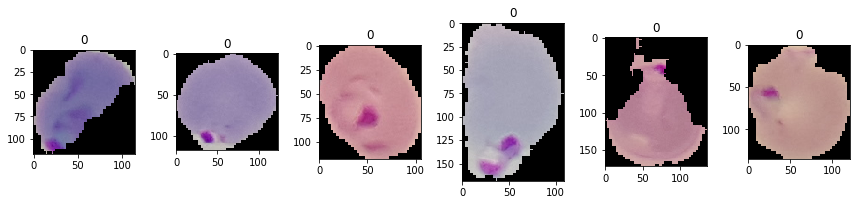

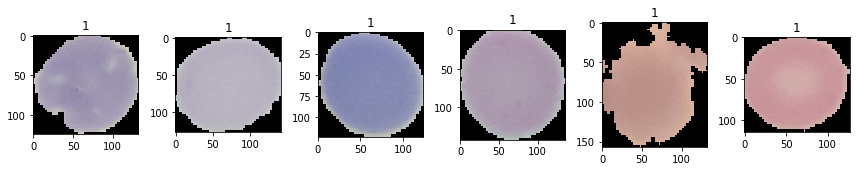

In [0]:
#plot class 0
plot_imgs(x, y, 0)

#plot class 1
plot_imgs(x, y, 1)

¿Can we spot the difference between class 0 and 1?


*   There are some dots in class 0.
*   Images have different sizes.



# **Data preprocessing**

Steps to follow for this problem:
- Train-test split
- Standarize size
- Resize
- One-hot encoding
- Pixel value normalization

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 666)

In [0]:
# Check shapes & distribution of the classes in the splits
print('Train')
print(x_train.shape, y_train.shape)
print(np.unique(y_train, return_counts=True))

print('Test')
print(x_test.shape, y_test.shape)
print(np.unique(y_test, return_counts=True))

Train
(19290,) (19290,)
(array([0, 1]), array([9614, 9676]))
Test
(8268,) (8268,)
(array([0, 1]), array([4165, 4103]))


Lets do it better by using **STRATIFICATION**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size = 0.3, random_state = 666)

# Check shapes & distribution of the classes in the splits
print('Train')
print(x_train.shape, y_train.shape)
print(np.unique(y_train, return_counts=True))

print('Test')
print(x_test.shape, y_test.shape)
print(np.unique(y_test, return_counts=True))

Train
(19290,) (19290,)
(array([0, 1]), array([9645, 9645]))
Test
(8268,) (8268,)
(array([0, 1]), array([4134, 4134]))


Check image sizes:


*   Mean
*   Min
*   Max



In [0]:
# h = height , w = width. Use test data only.
h_size = []
w_size = []
for img in x_test:
  h_size.append(img.shape[0])
  w_size.append(img.shape[1])
h_size, w_size = np.asarray(h_size), np.asarray(w_size)
print('Height')
print(np.min(h_size), np.mean(h_size), np.max(h_size))
print('Width')
print(np.min(w_size), np.mean(w_size), np.max(w_size))


Height
49 132.8178519593614 340
Width
46 132.47206095791 364


In [0]:
import cv2
size = 50

x_train_input = []
for i in range(len(x_train)):
  img = cv2.resize(x_train[i], (size, size))
  x_train_input.append(img)

x_train_input = np.asarray(x_train_input)
y_train_input = np.copy(y_train)

# Check size
print(x_train_input.shape, y_train_input.shape)

(19290, 50, 50, 3) (19290,)


In [0]:
# Data to categorical 
import keras
num_classes = 2
y_train_input = keras.utils.to_categorical(y_train_input, num_classes)

print(y_train_input.shape)

(19290, 2)


Using TensorFlow backend.


In [0]:
# Normalize the data
print(np.min(x_train_input), np.max(x_train_input))
x_train_input = x_train_input * 1.0 / 255.
print(np.min(x_train_input), np.max(x_train_input))

0 255
0.0 1.0


In [0]:
# Data is ready! 

print('Train')
print(x_train_input.shape, y_train_input.shape)

print('Test')
print(x_test.shape, y_test.shape)

#WAIT... APLLY THE SAME PREPROCESSING TO TEST TOO!!! -> CREATE A FUNCTION FOR THIS

Train
(19290, 50, 50, 3) (19290, 2)
Test
(8268,) (8268,)


In [0]:
def preprocess_data(x_input, y_input, num_classes, size):
  #This function does all the preprocessing needed

  x_output = []
  for i in range(len(x_input)):
    img = cv2.resize(x_input[i], (size, size))
    x_output.append(img)

  x_output = np.asarray(x_output)
  y_output = np.copy(y_input)

  x_output = x_output * 1.0 / 255.

  y_output = keras.utils.to_categorical(y_output, num_classes)
  return x_output, y_output

In [0]:
x_test_input, y_test_input = preprocess_data(x_test, y_test, num_classes, size)

In [0]:
# Data is ready! 
print('Train')
print(x_train_input.shape, y_train_input.shape)

print('Test')
print(x_test_input.shape, y_test_input.shape)

Train
(19290, 50, 50, 3) (19290, 2)
Test
(8268, 50, 50, 3) (8268, 2)


Yes, it is!!! How can we proceed now? It's time to build out classification CNN, let's do it!

# **DEEP LEARNING**

This section contains the training and evaluation of the different models and techniques such as 
* training from scratch
* fine-tuning
* data augmentation
* test time augmentation
* ...

## **Base model**

This is a model from scratch. We follow same basic steps for all the models:
- Build
- Train
- Evaluate

### **Build model**

In [0]:
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

In [0]:
def CNNbuild(height, width, classes, channels):

    model = Sequential()
    
    inputShape = (height, width, channels)

    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    return model

In [0]:
# Create the network
height = x_train_input.shape[1]
width = x_train_input.shape[2]
channels = x_train_input.shape[3]
print(height, width, channels)

model = CNNbuild(height = height, width = width, classes = num_classes, channels = channels)

#Visualize architecture
model.summary()

50 50 3



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 32)         

### **Model training**

In [0]:
# HYPERPARAMERTS
# We are going to use default parameters of Adam optimizer
epochs = 20
batch_size = 32

In [0]:
#compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

#train the model
h = model.fit(x_train_input, y_train_input, epochs = epochs, batch_size = batch_size, validation_data = (x_test_input, y_test_input))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 19290 samples, validate on 8268 samples
Epoch 1/20



19290/19290 [==============================] - 16s 854us/step - loss: 0.4331 - acc: 0.7888 - val_loss: 0.2113 - val_acc: 0.9289
Epoch 2/20
19290/19290 [==============================] - 4s 212us/step - loss: 0.1948 - acc: 0.9365 - val_loss: 0.1796 - val_acc: 0.9440
Epoch 3/20
19290/19290 [==============================] - 4s 212us/step - loss: 0.1721 - acc: 0.9457 - val_loss: 0.2088 - val_acc: 0.9342
Epoch 4/20
19290/19290 [==============================] - 4s 218us/step - loss: 0.1603 - acc: 0.9499 - val_loss: 0.1588 - val_acc: 0.9508
Epoch 5/20
19290/19290 [==============================] - 4s 207us/step - loss: 0.1553 - acc: 0.9507 - val_loss: 0.1609 - val_acc: 0.9505
Epoch 6/20
19290/19290 [==============================] - 4s 210us/step - loss: 0.1489 - acc: 0.9529 - val_loss: 0.1449 - val_acc: 0.9546
Epoch 7/20
19290/19290 [==============================] - 4s 210us/step - loss: 0.1469 - acc: 0.9547 - val_loss: 0.1427 - val_acc: 0.9542
Epoch 8/20
19290/19290 [====================

### **Model evaluation**

In [0]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix

y_pred = model.predict(x_test_input)

# The output is a softmax, we need to get the maximum [0.2,0.8] = 1 | [0.9,0.1] = 0 (Using argmax)
y_pred = np.argmax(y_pred, axis=-1)

acc = accuracy_score(y_test, y_pred)
bac = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy: ' + str(acc * 100.) + '%')
print('BAC: ' + str(bac * 100.) + '%')
print('F1 score: ' + str(f1 * 100.) + '%')

print(cm)

Accuracy: 95.58538945331398%
BAC: 95.58538945331398%
F1 score: 95.63553748654789%
[[3904  230]
 [ 135 3999]]


We can plot a nice confusion matrix to analyse it better

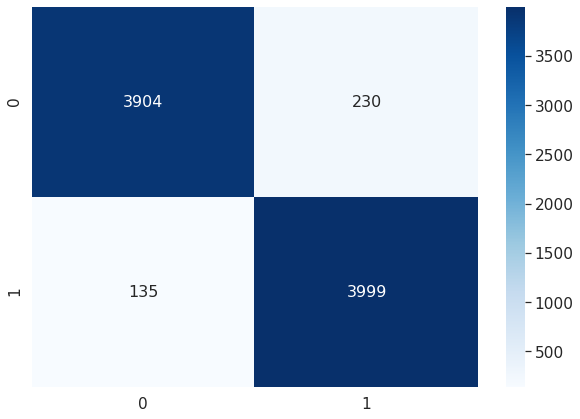

In [0]:
import pandas as pd
import seaborn as sn

cm_df = pd.DataFrame(cm, dtype=int)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm_df, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")

In [0]:
# Find missclassified samples
ind_error = []
for i in range(len(y_test)):
  if y_test[i] != y_pred[i]:
    ind_error.append(i)

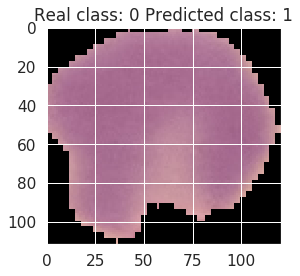

In [0]:
plt.imshow(x_test[ind_error[0]])
plt.title('Real class: ' + str(y_test[ind_error[0]]) + ' ' + 'Predicted class: ' + str(y_pred[ind_error[0]]))
plt.show()

## **Base model 2**

In [0]:
def CNNbuild_2(height, width, classes, channels):
  
  model = keras.Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=(height, width, 3)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  return model

In [0]:
# Create the network
height = x_train_input.shape[1]
width = x_train_input.shape[2]
channels = x_train_input.shape[3]
print(height, width, channels)

model_2 = CNNbuild_2(height = height, width = width, classes = num_classes, channels = channels)

#Visualize architecture
model_2.summary()

50 50 3
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_299 (Conv2D)          (None, 50, 50, 32)        896       
_________________________________________________________________
activation_283 (Activation)  (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_284 (Activation)  (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 24, 24, 64

In [0]:
#compile the model
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

#train the model
h = model_2.fit(x_train_input, y_train_input, epochs = epochs, batch_size = batch_size, validation_data = (x_test_input, y_test_input))

Train on 19290 samples, validate on 8268 samples
Epoch 1/20
19290/19290 [==============================] - 15s 798us/step - loss: 0.4431 - acc: 0.7694 - val_loss: 0.1638 - val_acc: 0.9516
Epoch 2/20
19290/19290 [==============================] - 8s 402us/step - loss: 0.1717 - acc: 0.9480 - val_loss: 0.1492 - val_acc: 0.9519
Epoch 3/20
19290/19290 [==============================] - 8s 401us/step - loss: 0.1523 - acc: 0.9529 - val_loss: 0.1446 - val_acc: 0.9522
Epoch 4/20
19290/19290 [==============================] - 8s 398us/step - loss: 0.1490 - acc: 0.9551 - val_loss: 0.1531 - val_acc: 0.9507
Epoch 5/20
19290/19290 [==============================] - 8s 400us/step - loss: 0.1451 - acc: 0.9553 - val_loss: 0.1669 - val_acc: 0.9521
Epoch 6/20
19290/19290 [==============================] - 8s 403us/step - loss: 0.1395 - acc: 0.9560 - val_loss: 0.1328 - val_acc: 0.9578
Epoch 7/20
19290/19290 [==============================] - 8s 397us/step - loss: 0.1384 - acc: 0.9569 - val_loss: 0.1560 - 

## **Base model with augmentation**

### **Build model**
Here we use model or model_2

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Now we will create a generator
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train_input, y_train_input, batch_size = 64, shuffle = False)
test_generator = test_datagen.flow(x_test_input, y_test_input, batch_size = 64, shuffle = False)

### **Model training**

In [0]:
optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

#fit the model on the augmented dataset
h_aug = model.fit_generator(train_generator, steps_per_epoch = len(x_train) // 64, epochs = 10, validation_data=test_generator)

Epoch 1/10
301/301 [==============================] - 14s 46ms/step - loss: 0.2746 - acc: 0.8981 - val_loss: 0.1390 - val_acc: 0.9548
Epoch 2/10
301/301 [==============================] - 13s 43ms/step - loss: 0.2650 - acc: 0.9054 - val_loss: 0.1441 - val_acc: 0.9526
Epoch 3/10
301/301 [==============================] - 13s 44ms/step - loss: 0.2584 - acc: 0.9057 - val_loss: 0.1394 - val_acc: 0.9539
Epoch 4/10
301/301 [==============================] - 13s 43ms/step - loss: 0.2595 - acc: 0.9056 - val_loss: 0.1360 - val_acc: 0.9556
Epoch 5/10
301/301 [==============================] - 13s 44ms/step - loss: 0.2489 - acc: 0.9123 - val_loss: 0.1373 - val_acc: 0.9543
Epoch 6/10
301/301 [==============================] - 13s 43ms/step - loss: 0.2500 - acc: 0.9097 - val_loss: 0.1399 - val_acc: 0.9542
Epoch 7/10
301/301 [==============================] - 13s 43ms/step - loss: 0.2485 - acc: 0.9095 - val_loss: 0.1431 - val_acc: 0.9540
Epoch 8/10
301/301 [==============================] - 13s 43ms

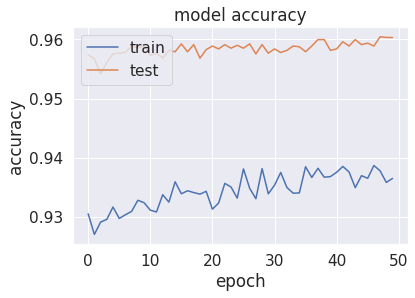

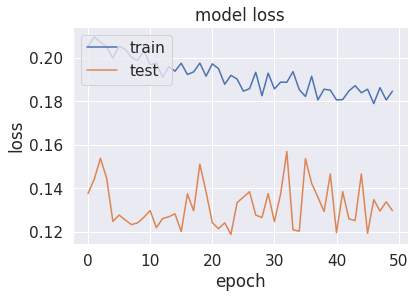

In [0]:
# Here we are going to visualize training:
# summarize history for accuracy
plt.plot(h_aug.history['acc'])
plt.plot(h_aug.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h_aug.history['loss'])
plt.plot(h_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Training loss is still greater than test, we should train for more epochs...

In [0]:
optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model_2.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

#fit the model on the augmented dataset
h_aug = model_2.fit_generator(train_generator, steps_per_epoch = len(x_train) // 64, epochs = 50, validation_data=test_generator)

Epoch 1/50
301/301 [==============================] - 27s 89ms/step - loss: 0.2051 - acc: 0.9306 - val_loss: 0.1375 - val_acc: 0.9574
Epoch 2/50
301/301 [==============================] - 20s 65ms/step - loss: 0.2099 - acc: 0.9270 - val_loss: 0.1441 - val_acc: 0.9567
Epoch 3/50
301/301 [==============================] - 20s 65ms/step - loss: 0.2074 - acc: 0.9291 - val_loss: 0.1538 - val_acc: 0.9542
Epoch 4/50
301/301 [==============================] - 20s 65ms/step - loss: 0.2051 - acc: 0.9296 - val_loss: 0.1445 - val_acc: 0.9561
Epoch 5/50
301/301 [==============================] - 19s 64ms/step - loss: 0.1999 - acc: 0.9317 - val_loss: 0.1247 - val_acc: 0.9575
Epoch 6/50
301/301 [==============================] - 19s 64ms/step - loss: 0.2058 - acc: 0.9296 - val_loss: 0.1276 - val_acc: 0.9577
Epoch 7/50
301/301 [==============================] - 19s 64ms/step - loss: 0.2039 - acc: 0.9304 - val_loss: 0.1253 - val_acc: 0.9578
Epoch 8/50
301/301 [==============================] - 19s 64ms

### **Model evaluation**

In [0]:
y_pred = model_aug.predict(x_test_input)

# The output is a softmax, we need to get the maximum [0.2,0.8] = 1 | [0.9,0.1] = 0 (Using argmax)
y_pred = np.argmax(y_pred, axis=-1)

acc = accuracy_score(y_test, y_pred)
bac = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy: ' + str(acc * 100.) + '%')
print('BAC: ' + str(bac * 100.) + '%')
print('F1 score: ' + str(f1 * 100.) + '%')

print(cm)

Accuracy: 94.93226898887276%
BAC: 94.93226898887276%
F1 score: 94.99462429817227%
[[3873  261]
 [ 158 3976]]


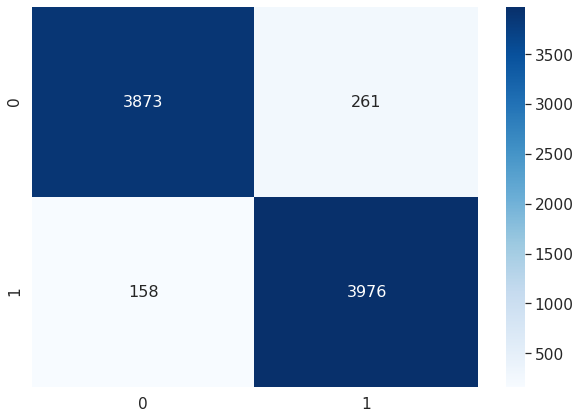

In [0]:
cm_df = pd.DataFrame(cm, dtype=int)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm_df, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")

## **Fine-tuning from ImageNet**


### **Build model**

In [0]:
def select_model(network):
  if network == 'DenseNet169':
    model = keras.applications.densenet.DenseNet169(include_top=False, weights='imagenet')
  elif network == 'DenseNet201':
      model = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet')
  elif network == 'DenseNet121':
      model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet')
  elif network == 'ResNet50':
      model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
  elif network == 'InceptionV3':
      model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')
  elif network == 'InceptionResNetV2':
      model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')
  elif network == 'Xception':
      model = keras.applications.xception.Xception(include_top=False, weights='imagenet')
  elif network == 'MobileNet':
      model = keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet')
  elif network == 'MobileNetV2':
      model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
  else:
      print('Wrong model name, DenseNet121 chosen as default')
      model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet')

  return model

In [0]:
# Choose network
network_list = ['DenseNet121', 'DenseNet169', 'DenseNet201',
                    'ResNet50', 'InceptionV3', 'InceptionResNetV2',
                    'Xception', 'MobileNet', 'MobileNetV2']

network = network_list[4]
trainable_layers = 3

model_pre = select_model(network)

# Add necessary layers
output = keras.layers.GlobalAveragePooling2D()(model_pre.output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dropout(0.5)(output)
# output = keras.layers.Dense(32, activation='relu')(output)
# output = keras.layers.Dropout(0.25)(output)
# output = keras.layers.Dense(16, activation='relu')(output)
output = keras.layers.Dense(num_classes, activation='softmax')(output)
pretrained_model = keras.models.Model(model_pre.inputs, output)

if trainable_layers != -1:
    #Do not set to false batchnormalization layers! These are essential
    for layer in pretrained_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.momentum = 0.9
    for layer in pretrained_model.layers[:-trainable_layers]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

pretrained_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
____________________________________________________________________________________________

We want bigger images and preprocessing function should be different here.

In [0]:
def preprocess_data(x_input, y_input, num_classes, size, network):

  x_output = []
  for i in range(len(x_input)):
    img = cv2.resize(x_input[i], (size, size))
    x_output.append(img)

  x_output = np.asarray(x_output)
  y_output = np.copy(y_input)

  # Now we apply the correspondent preprocessing
  if network == 'DenseNet121' or network == 'DenseNet169' or network == 'DenseNet201':
    x_output = keras.applications.densenet.preprocess_input(x_output)

  elif network == 'ResNet50':
    x_output = keras.applications.resnet50.preprocess_input(x_output)

  elif network == 'InceptionV3':
    x_output = keras.applications.inception_v3.preprocess_input(x_output)

  elif network == 'InceptionResNetV2':
    x_output = keras.applications.inception_resnet_v2.preprocess_input(x_output)

  elif network == 'Xception':
    x_output = keras.applications.xception.preprocess_input(x_output)

  elif network == 'MobileNet':
    x_output = keras.applications.mobilenet.preprocess_input(x_output)

  elif network == 'MobileNetV2':
    x_output = keras.applications.mobilenet_v2.preprocess_input(x_output)

  y_output = keras.utils.to_categorical(y_output, num_classes)
  return x_output, y_output

In [0]:
x_train_finetune, y_train_fine_tune = preprocess_data(x_train, y_train, num_classes, 100, network)
x_test_finetune, y_test_fine_tune = preprocess_data(x_test, y_test, num_classes, 100, network)

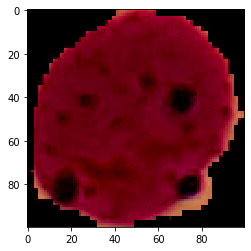

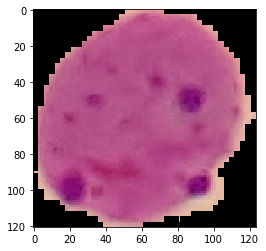

In [0]:
plt.imshow(x_train_finetune[2])
plt.show()
plt.imshow(x_train[2])
plt.show()

In [0]:
# Data is ready! 
print('Train')
print(x_train_finetune.shape, y_train_fine_tune.shape)

print('Test')
print(x_test_finetune.shape, y_test_fine_tune.shape)

Train
(19290, 100, 100, 3) (19290, 2)
Test
(8268, 100, 100, 3) (8268, 2)


In [0]:
#What about the min and max?
print(np.min(x_train_finetune), np.max(x_train_finetune))
print(np.min(x_test_finetune), np.max(x_test_finetune))

-1.0 1.0
-1.0 1.0


In [0]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen_finetune = ImageDataGenerator(horizontal_flip = True,
#                                   fill_mode = 'nearest',
#                                   zoom_range = 0.3,
#                                   rotation_range = 30)

# test_datagen_finetune = ImageDataGenerator()

# train_generator_finetune = train_datagen_finetune.flow(x_train_finetune_224, y_train_fine_tune, batch_size = 16, shuffle = False)
# test_generator_finetune = test_datagen_finetune.flow(x_test_finetune_224, y_test_fine_tune, batch_size = 16, shuffle = False)

### **Model training**

In [0]:
optim = keras.optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
pretrained_model.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

#fit the model on the augmented dataset
# h_aug = pretrained_model.fit_generator(train_generator_finetune, steps_per_epoch = len(x_train) // 64, epochs = 10, validation_data=test_generator_finetune)
h = pretrained_model.fit(x_train_finetune, y_train_fine_tune, epochs = 20, batch_size = 32, validation_data = (x_test_finetune, y_test_fine_tune))